In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [ ]:
datasetpath = '/content/IMDB Dataset.csv'
df = pd.read_csv(datasetpath)

print(".................top 10 rows of Dataframe................")
print(df.head(10))


df['sentiment'] = df['sentiment'].apply(lambda x: 1 if x == 'positive' else 0)


df = df.sample(frac=1, random_state=1234).reset_index(drop=True)

#divide dataset into 80% of train data and 20% test data

traindf = df.iloc[:int(len(df)*0.8)]
testdf = df.iloc[int(len(df)*0.8):]


print("Size of Train dataset:", len(traindf), "Size of Test dataset:", len(testdf))

.................top 10 rows of Dataframe................
                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive
5  Probably my all-time favorite movie, a story o...  positive
6  I sure would like to see a resurrection of a u...  positive
7  This show was an amazing, fresh & innovative i...  negative
8  Encouraged by the positive comments about this...  negative
9  If you like original gut wrenching laughter yo...  positive
Size of Train dataset: 40000 Size of Test dataset: 10000


In [ ]:
traindf.head(10)

,review,sentiment
0,Although this film was made before Dogme emerg...,0
1,My grandmother took me and my sister out to se...,0
2,Possibly the worst film within the genre in ex...,0
3,As long as you keep in mind that the productio...,0
4,The plot in Petites Coupures certainly left th...,0
5,this is quite possibly the worst acting i have...,0
6,I watched this movie alongwith my complete fam...,1
7,Ever since I can remember and I'm only 18 my m...,1
8,"Before this clip, music videos were merely to ...",1
9,Just Cause is one of those films that at first...,0


In [ ]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english')) # to remove all that doesn't carry meaningful information such words a,an,the, off

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
text = df.iloc[22]['review'] #returns the 32 entry from dataframe
text

"I like this presentation - I have read Bleak House and I know it is so difficult to present the entire book as it should be, and even others like Little Dorrit - I have to admit they did a very good show with the staged Nicholas Nickelby. I love Diana Rigg and I could see the pain of Lady Dedlock, even through the expected arrogance of the aristocracy. I am sorry, I think she is the best Lady Dedlock... I am not sure who could have made a better Jarndyce, but I am OK with Mr. Elliott. It is not easy to present these long Dickens' books - Oliver Twist would be easier - this is a long, and if you don't care for all the legal situations can be dreary or boring. I think this presentation is entertaining enough not to be boring. I just LOVED Mr. Smallweed - it can be entertaining. There is always a child - Jo will break your heart here... I think we should be given a chance to judge for ourselves...<br /><br />I have to say I loved the show. Maybe if I read the book again, as I usually do,

In [ ]:
import re
from collections import Counter
from torchtext.data.utils import get_tokenizer

tokenizer = get_tokenizer('basic_english')

replacements = {
    r"<br /><br />": " ",
    r"\#": "",
    r"http\S+": "URL",
    r"@" : "",
    r"[^A-Za-z0-9()!?\'\`\"]": " ",
    "\s{2,}": " "
}

# we convert all tesxt to lowercase and strips leading/trailing spaces
def stringnormalization(text):
    text = text.lower().strip()

    for pattern, replacement in replacements.items():
        text = re.sub(pattern, replacement, text)

    return text

def tokennormalization(text):
    text_tokens = tokenizer(text)
    filtered_tokens = [token for token in text_tokens if token not in stop_words]
    return filtered_tokens

totalsentences = df["review"]
totalsentences = totalsentences.apply(stringnormalization)
totaltokens = list(totalsentences.apply(tokennormalization))

# Collected unique tokens from the dataset and filter based on their frequency
wordfrequency = Counter([token for sublist in totaltokens for token in sublist]) #counts frequency of each word

# words which occur atleast  5 times will be stored in our vocabulary

vocab = []
for word, freq in wordfrequency.items():
    if freq >= 5:
        vocab.append(word)

vocab = ['<pad>'] + vocab #only main words are present

print(len(vocab))
print(vocab[:100])

# Count the number of tokens per data point
token_counts = []
for data_point in totaltokens:
    token_counts.append(len(data_point))



39629
['<pad>', 'although', 'film', 'made', 'dogme', 'emerged', 'predominant', 'method', 'filmmaking', 'digital', 'triumphed', 'strike', 'get', 'point', '1991', 'masterpiece', 'clearly', 'anticipated', 'developments', 'corin', 'nemec', 'outstanding', 'ne', "'", 'er', 'well', 'author', 'narrator', 'pace', 'slow', 'elegantly', 'cinematography', 'beautiful', 'record', 'next', 'time', 'v', 'guarantee', 'never', 'see', 'better', 'nostalgia', 'rip', 'movie', 'direct', 'video', 'felt', 'good', '!', 'grandmother', 'took', 'sister', 'came', 'theaters', 'back', '1998', 'happily', 'bought', 'tickets', 'popcorn', 'soda', 'walked', 'right', 'theater', 'sat', 'watch', 'audience', 'applauded', 'strongly', 'remember', 'heard', 'people', 'say', 'like', 'thought', 'rather', 'stupid', 'worth', 'seeing', 'eddie', 'murphy', 'hysterical', 'apart', 'whole', 'bad', 'rarely', 'laughed', 'parts', 'also', 'remembered', 'almost', 'hardly', 'even', 'really', 'making', 'animals', 'talk', 'talking', 'exist', 'cartoo

In [ ]:
import torch
from torch.utils.data import Dataset

class CustomDataset(Dataset):
    def __init__(self, df, tokenizer, vocab, max_length=500):
        self.data = df['review']
        self.targets = df['sentiment']
        self.max_length = max_length
        self.tokenizer = tokenizer
        self.vocab_dict = {token: index for index, token in enumerate(vocab)}

    def __len__(self):
        return len(self.data)

    def process_text(self, text):
        text = stringnormalization(text)
        word_tokens = tokennormalization(text)
        return word_tokens

    def transform_tokens_to_ids(self, tokens):
        truncated_tokens = tokens[:self.max_length]
        ids = [self.vocab_dict[word] for word in truncated_tokens if self.vocab_dict.get(word) is not None]
        return ids

    def __getitem__(self, index):
        data_point = self.data.iloc[index]
        word_tokens = self.process_text(data_point)
        data_ids = self.transform_tokens_to_ids(word_tokens)
        target = self.targets.iloc[index]

        return torch.tensor(data_ids), target


Here it is loading the GloVe word embeddings. The '6B' argument refers to the GloVe model trained on 6 billion words from Wikipedia and Gigaword. The 'dim=100' argument specifies that the word vectors should have 100 dimensions. Creates a 100 dimensional vector for each word

In [ ]:
# from torchtext.vocab import GloVe

# glove = GloVe(name='6B', dim=100)

# embedding_matrix = np.zeros((len(vocab), 100))

# for i, token in enumerate(vocab):
#     embedding_matrix[i] = glove[token]

# np.save('embeddings.npy', embedding_matrix)

In [ ]:
from torchtext.vocab import GloVe
import numpy as np

# Initializing GloVe with 100 dimensional vectors
glove = GloVe(name='6B', dim=100)

# creating the zero matrix for the embedding matrix
embedding_dim = 100
vocab_size = len(vocab)
embedding_matrix = np.zeros((vocab_size, embedding_dim))

# now we will fill embedding matrix with GloVe vectors
for i in range(vocab_size):
    token = vocab[i]
    embedding_matrix[i] = glove[token]

print(embedding_matrix)

# Save the embedding matrix to a file
embedding_filename = 'embeddings.npy'
np.save(embedding_filename, embedding_matrix)



.vector_cache/glove.6B.zip: 862MB [02:39, 5.39MB/s]                           
100%|█████████▉| 399999/400000 [00:21<00:00, 18888.29it/s]


[[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [-0.31843001  0.33155     0.1735     ... -0.086687    0.1937
  -0.22784001]
 [ 0.19915999 -0.049702    0.24579    ... -0.068109    0.017651
   0.06455   ]
 ...
 [-0.29157001 -0.61574    -0.18811999 ...  0.042986   -0.43873999
  -0.38499999]
 [-0.55757999 -0.67988998 -0.59139001 ...  0.74598002 -0.028291
   0.020271  ]
 [ 0.24415    -0.33618    -0.22695    ...  0.44402    -0.80962998
   0.57736999]]


In [ ]:
embeddingmatrix = np.load('embeddings.npy')

In [ ]:
embeddingmatrix[394]

array([ 2.63000011e-01,  1.26890004e-01,  4.45410013e-01, -1.51669994e-01,
        4.23860013e-01,  6.13730013e-01,  2.11879998e-01, -3.79980006e-03,
        3.48259985e-01, -2.58320004e-01,  4.24499989e-01,  3.25089991e-01,
        6.24350011e-01,  2.34190002e-01,  2.43910000e-01, -2.93599993e-01,
        5.73660016e-01, -5.58019988e-02, -1.36510000e-01,  1.23389997e-01,
        2.31110007e-02, -7.84580037e-02, -4.28379998e-02, -5.46199977e-01,
       -7.32169999e-03, -2.94559985e-01, -6.07760012e-01, -2.28880003e-01,
       -3.00089985e-01,  5.98770007e-02,  4.20910001e-01,  3.13309997e-01,
       -2.39999995e-01,  3.35629992e-02,  4.51819986e-01, -2.58489996e-01,
       -6.36700019e-02, -2.87490010e-01,  7.57569969e-02, -6.61640018e-02,
       -8.98770019e-02,  3.08679998e-01,  4.47609991e-01, -3.48690003e-02,
       -8.41389969e-02, -3.62379998e-01,  1.86240003e-01,  2.58560002e-01,
        1.63010001e-01, -5.76910019e-01,  1.48110002e-01,  1.98520005e-01,
        5.39629996e-01,  

In [ ]:
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader

def collate_batch(batch):


    sorted_batch = sorted(batch, key=lambda x: len(x[0]), reverse=True)

    sequences, labels = zip(*sorted_batch)


    l = []
    for seq in sequences:
      l.append(len(seq))


    padded_sequences = pad_sequence(sequences, batch_first=True)

    return padded_sequences, torch.tensor(labels, dtype=torch.float32)

batch_size = 32

train_data = CustomDataset(traindf, tokenizer, vocab)
test_data = CustomDataset(testdf, tokenizer, vocab)

train_dataloader = DataLoader(train_data, batch_size=batch_size, collate_fn=collate_batch, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, collate_fn=collate_batch, shuffle=False)


In [ ]:
 vocab.index('<pad>')

0

In [ ]:
sentence, label = next(iter(train_dataloader))
print(label)
print(sentence.shape)
print(sentence)

tensor([1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 1., 1., 0.,
        0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 1., 1., 1., 0.])
torch.Size([32, 355])
tensor([[ 5179,  5180,    23,  ...,   200,   710,  7054],
        [ 2551,  2997,  8238,  ...,     0,     0,     0],
        [ 6269,  1619,  3646,  ...,     0,     0,     0],
        ...,
        [ 1289,  7128, 11570,  ...,     0,     0,     0],
        [  113,   529,    43,  ...,     0,     0,     0],
        [  594, 14650,    43,  ...,     0,     0,     0]])


In [ ]:
import torch.nn as nn

class LSTM(nn.Module):
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers):
        super(LSTM, self).__init__()

        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.encoder = nn.LSTM(embed_size, num_hiddens, num_layers=num_layers, bidirectional=True)
        self.decoder = nn.Linear(4*num_hiddens, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, inputs):
        embeddings = self.embedding(inputs.T)
        self.encoder.flatten_parameters()
        outputs, _ = self.encoder(embeddings)
        encoding = torch.cat((outputs[0], outputs[-1]), dim=1)
        result = self.sigmoid(self.decoder(encoding).squeeze())
        return result


In [ ]:
embed_size, num_hiddens, num_layers, device = 100, 100, 2, torch.device("cuda" if torch.cuda.is_available() else "cpu")

network = LSTM(len(vocab), embed_size, num_hiddens, num_layers)

network.to(device)

def init_weights(module):
    if type(module) == nn.Linear:
        nn.init.xavier_uniform_(module.weight)
    if type(module) == nn.LSTM:
        for param in module._flat_weights_names:
            if "weight" in param:
                nn.init.xavier_uniform_(module._parameters[param])
network.apply(init_weights)

LSTM(
  (embedding): Embedding(39629, 100)
  (encoder): LSTM(100, 100, num_layers=2, bidirectional=True)
  (decoder): Linear(in_features=400, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [ ]:
network.embedding.weight.data.copy_(torch.tensor(embedding_matrix))
network.embedding.weight.requires_grad = False

num_epochs =  10
optimizer = torch.optim.Adam(network.parameters(), lr=0.01)
loss = nn.BCELoss()

In [ ]:
import time
import numpy as np
import torch
import numpy as np
from torch.nn import functional as F

def train(model, optimizer, num_epochs, train_dataloader, val_dataloader, device, loss_fn):
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    for epoch_i in range(num_epochs):
        print(f'======== Epoch {epoch_i+1} / {num_epochs} ========')
        print('Training...')

        total_train_loss = 0
        total_train_acc = 0

        model.train()
        for i, batch in enumerate(train_dataloader):
            inputs, labels = [t.to(device) for t in batch]

            optimizer.zero_grad()
            outputs = model(inputs)
            train_loss = loss_fn(outputs, labels)
            correct = sum((outputs>0.5) == labels)
            train_acc = float(correct) / float(len(labels.data)) * 100.0


            total_train_loss += train_loss.item()
            total_train_acc += train_acc


            train_loss.backward()
            optimizer.step()

        avg_train_loss = total_train_loss / len(train_dataloader)
        avg_train_acc = total_train_acc / len(train_dataloader)
        train_losses.append(avg_train_loss)
        train_accuracies.append(avg_train_acc)
        print(f'Training Loss: {avg_train_loss:.3f}, Training acc: {avg_train_acc:.3f}')


        print('Validation...')

        model.eval()
        total_val_loss = 0
        total_val_acc = 0

        with torch.no_grad():
            for batch in val_dataloader:
                inputs, labels = [t.to(device) for t in batch]
                outputs = model(inputs)
                val_loss = loss_fn(outputs, labels)
                correct = sum((outputs>0.5) == labels)
                val_acc = float(correct) / float(len(labels.data)) * 100.0

                total_val_loss += val_loss.item()
                total_val_acc += val_acc

        avg_val_loss = total_val_loss / len(val_dataloader)
        avg_val_acc = total_val_acc / len(val_dataloader)
        val_losses.append(avg_val_loss)
        val_accuracies.append(avg_val_acc)

        print(f'Validation Loss: {avg_val_loss:.3f}, Validation acc: {avg_val_acc:.3f}')


    return train_losses, val_losses, train_accuracies, val_accuracies


In [ ]:
train_losses, test_losses, train_accuracies, test_accuracies = train(network, optimizer, num_epochs, train_dataloader,
                                          test_dataloader, device, loss)

======== Epoch 1 / 10 ========
Training...
Training Loss: 0.432, Training acc: 79.355
Validation...
Validation Loss: 0.341, Validation acc: 85.603
======== Epoch 2 / 10 ========
Training...
Training Loss: 0.334, Training acc: 85.925
Validation...
Validation Loss: 0.321, Validation acc: 86.442
======== Epoch 3 / 10 ========
Training...
Training Loss: 0.308, Training acc: 87.138
Validation...
Validation Loss: 0.304, Validation acc: 87.370
======== Epoch 4 / 10 ========
Training...
Training Loss: 0.278, Training acc: 88.562
Validation...
Validation Loss: 0.307, Validation acc: 87.061
======== Epoch 5 / 10 ========
Training...
Training Loss: 0.265, Training acc: 89.175
Validation...
Validation Loss: 0.305, Validation acc: 87.111
======== Epoch 6 / 10 ========
Training...
Training Loss: 0.251, Training acc: 89.775
Validation...
Validation Loss: 0.312, Validation acc: 87.320
======== Epoch 7 / 10 ========
Training...
Training Loss: 0.244, Training acc: 90.075
Validation...
Validation Loss: 0

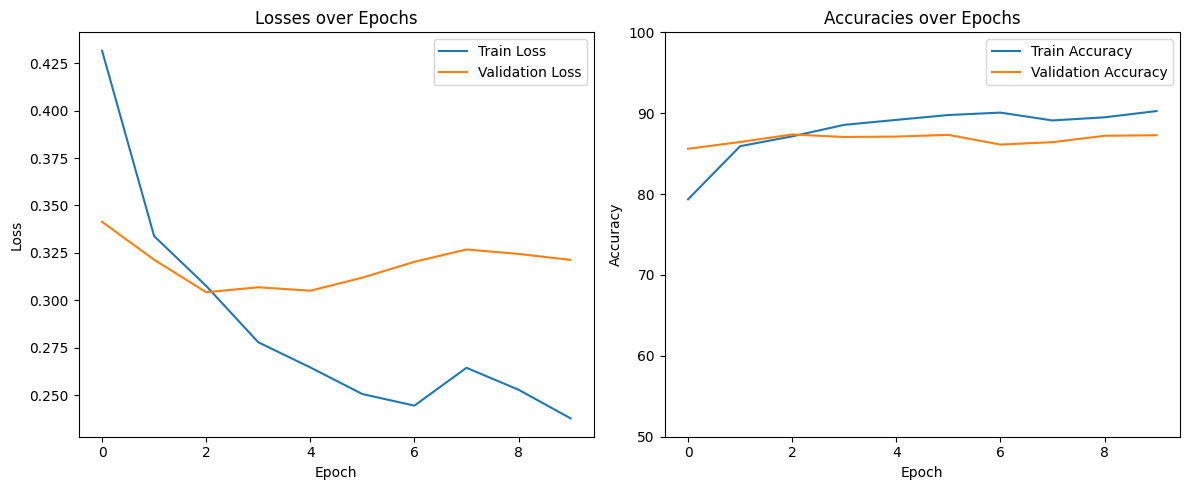

In [ ]:
def plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Losses over Epochs")

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.ylim((50, 100))
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.title("Accuracies over Epochs")

    plt.tight_layout()
    plt.show()

plot_metrics(train_losses, test_losses, train_accuracies, test_accuracies)


In [ ]:
def predict_sentiment(network, vocab_dict, sequence):
    sequence = tokenizer(sequence)
    sequence = [vocab_dict.get(word, vocab_dict['<pad>']) for word in sequence]

    sequence = torch.tensor([sequence], device=device)
    output = network(sequence)
    return 'positive' if output > 0.5 else 'negative'

vocab_dict = {token: index for index, token in enumerate(vocab)}

# we are selecting 10 random sentences from the dataset
random_samples = df.sample(10)


for i, row in random_samples.iterrows():
    sentence = row['review']
    actual_sentiment = 'positive' if row['sentiment'] == 1 else 'negative'
    predicted_sentiment = predict_sentiment(network, vocab_dict, sentence)

    print(f"Sentence {i+1}: {sentence[:250]}...")
    print(f"Actual Sentiment: {actual_sentiment}")
    print(f"Predicted Sentiment: {predicted_sentiment}")
    print("-"*50)

Sentence 14050: Richard Attenborough is a director whose name is synonymous with the Academy Award winning 'Gandhi', back in '83. I didn't know of any other work of his till i recently came across 'Cry Freedom', released back in 1987. While it may not have been as p...
Actual Sentiment: positive
Predicted Sentiment: positive
--------------------------------------------------
Sentence 36681: The larger-than-life figures of Wyatt Earp and Bat Masterson, and the specters of George Armstrong Custer and Sitting Bull, loom over director Anthony Mann's hugely entertaining first western with James Stewart. Although Stewart's quest to avenge his...
Actual Sentiment: positive
Predicted Sentiment: positive
--------------------------------------------------
Sentence 19128: I recently had to watch this for a project in a Sociology class and thought it was absolutely the worst movie I have ever had to sit through. It was like bad a bad cinemax movie with all the "good bits" taken out. Bad acting, th

learning rate 0.001

In [ ]:
network.embedding.weight.data.copy_(torch.tensor(embedding_matrix))
network.embedding.weight.requires_grad = False

num_epochs =  10
optimizer = torch.optim.Adam(network.parameters(), lr=0.001)
loss = nn.BCELoss()

In [ ]:
import time
import numpy as np
import torch
import numpy as np
from torch.nn import functional as F

def train(model, optimizer, num_epochs, train_dataloader, val_dataloader, device, loss_fn):
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    for epoch_i in range(num_epochs):
        print(f'======== Epoch {epoch_i+1} / {num_epochs} ========')
        print('Training...')

        total_train_loss = 0
        total_train_acc = 0

        model.train()
        for i, batch in enumerate(train_dataloader):
            inputs, labels = [t.to(device) for t in batch]

            optimizer.zero_grad()
            outputs = model(inputs)
            train_loss = loss_fn(outputs, labels)
            correct = sum((outputs>0.5) == labels)
            train_acc = float(correct) / float(len(labels.data)) * 100.0


            total_train_loss += train_loss.item()
            total_train_acc += train_acc
            train_loss.backward()
            optimizer.step()

        avg_train_loss = total_train_loss / len(train_dataloader)
        avg_train_acc = total_train_acc / len(train_dataloader)
        train_losses.append(avg_train_loss)
        train_accuracies.append(avg_train_acc)
        print(f'Training Loss: {avg_train_loss:.3f}, Training acc: {avg_train_acc:.3f}')


        print('Validation...')

        model.eval()
        total_val_loss = 0
        total_val_acc = 0

        with torch.no_grad():
            for batch in val_dataloader:
                inputs, labels = [t.to(device) for t in batch]
                outputs = model(inputs)
                val_loss = loss_fn(outputs, labels)
                correct = sum((outputs>0.5) == labels)
                val_acc = float(correct) / float(len(labels.data)) * 100.0

                total_val_loss += val_loss.item()
                total_val_acc += val_acc

        avg_val_loss = total_val_loss / len(val_dataloader)
        avg_val_acc = total_val_acc / len(val_dataloader)
        val_losses.append(avg_val_loss)
        val_accuracies.append(avg_val_acc)

        print(f'Validation Loss: {avg_val_loss:.3f}, Validation acc: {avg_val_acc:.3f}')


    return train_losses, val_losses, train_accuracies, val_accuracies


In [ ]:
train_losses, test_losses, train_accuracies, test_accuracies = train(network, optimizer, num_epochs, train_dataloader,
                                          test_dataloader, device, loss)

======== Epoch 1 / 10 ========
Training...
Training Loss: 0.174, Training acc: 93.075
Validation...
Validation Loss: 0.337, Validation acc: 87.530
======== Epoch 2 / 10 ========
Training...
Training Loss: 0.139, Training acc: 94.843
Validation...
Validation Loss: 0.364, Validation acc: 87.640
======== Epoch 3 / 10 ========
Training...
Training Loss: 0.117, Training acc: 95.815
Validation...
Validation Loss: 0.395, Validation acc: 87.570
======== Epoch 4 / 10 ========
Training...
Training Loss: 0.098, Training acc: 96.677
Validation...
Validation Loss: 0.465, Validation acc: 87.829
======== Epoch 5 / 10 ========
Training...
Training Loss: 0.085, Training acc: 97.210
Validation...
Validation Loss: 0.452, Validation acc: 87.510
======== Epoch 6 / 10 ========
Training...
Training Loss: 0.070, Training acc: 97.830
Validation...
Validation Loss: 0.500, Validation acc: 87.560
======== Epoch 7 / 10 ========
Training...
Training Loss: 0.059, Training acc: 98.282
Validation...
Validation Loss: 0

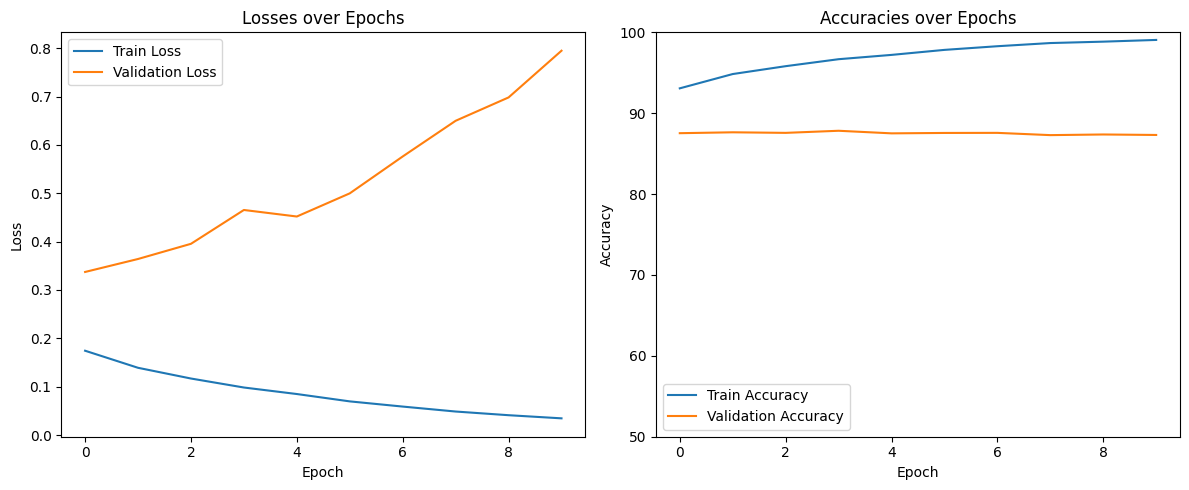

In [ ]:
def plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Losses over Epochs")

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.ylim((50, 100))
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.title("Accuracies over Epochs")

    plt.tight_layout()
    plt.show()

plot_metrics(train_losses, test_losses, train_accuracies, test_accuracies)


In [ ]:
def predict_sentiment(network, vocab_dict, sequence):
    sequence = tokenizer(sequence)
    sequence = [vocab_dict.get(word, vocab_dict['<pad>']) for word in sequence]

    sequence = torch.tensor([sequence], device=device)
    output = network(sequence)
    return 'positive' if output > 0.5 else 'negative'

# Your vocab dictionary
vocab_dict = {token: index for index, token in enumerate(vocab)}

# Select 10 random sentences from the dataset
random_samples = df.sample(10)

# Predict sentiment for each sentence
for i, row in random_samples.iterrows():
    sentence = row['review']
    actual_sentiment = 'positive' if row['sentiment'] == 1 else 'negative'
    predicted_sentiment = predict_sentiment(network, vocab_dict, sentence)

    print(f"Sentence {i+1}: {sentence[:250]}...")
    print(f"Actual Sentiment: {actual_sentiment}")
    print(f"Predicted Sentiment: {predicted_sentiment}")
    print("-"*50)

Sentence 42146: David Cronenberg's `eXistenZ' is a well designed reflection of the philosophy of existentialism. It addresses the problems of a culture that is plugged into technology that it can no longer distinguish between fantasy and reality or between the organ...
Actual Sentiment: positive
Predicted Sentiment: positive
--------------------------------------------------
Sentence 12460: With all the hype surrounding the stars of the movie, this movie left me wanting. I expected a much better movie considering the inclusion of the talents of Murphy, De Niro and Russo but found that the movie fell flat on it's face. Comedy sequences w...
Actual Sentiment: negative
Predicted Sentiment: negative
--------------------------------------------------
Sentence 37250: Not even Bob Hope, escorted by a raft of fine character actors, can save this poorly written attempt at wartime comedy, as his patented timing has little which which to work. The plot involves a Hollywood film star named Don Bol